In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os

In [7]:
# Set base path
BASE_DIR = r"C:\Users\NITRO V\RPI_Project\dataset"

IMG_SIZE = 224
BATCH_SIZE = 32

# Generators (no augmentation for baseline)
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_data = train_gen.flow_from_directory(
    os.path.join(BASE_DIR, "train"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_data = val_gen.flow_from_directory(
    os.path.join(BASE_DIR, "val"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

test_data = test_gen.flow_from_directory(
    os.path.join(BASE_DIR, "test"),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

Found 1400 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [37]:
# Build MobileNetV2 model
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False  # freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.4)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

In [38]:
# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [39]:
# Add EarlyStopping
early_stop = EarlyStopping(
    monitor="val_loss",   # Stop when validation loss stops improving
    patience=5,           
    restore_best_weights=True  
)

In [40]:
# Train classifier head (Phase 1)
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    callbacks=[early_stop]
)

Epoch 1/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9336 - loss: 0.1692 - val_accuracy: 0.9933 - val_loss: 0.0374
Epoch 2/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9993 - loss: 0.0218 - val_accuracy: 0.9967 - val_loss: 0.0268
Epoch 3/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9993 - loss: 0.0127 - val_accuracy: 0.9967 - val_loss: 0.0138
Epoch 4/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9993 - loss: 0.0085 - val_accuracy: 1.0000 - val_loss: 0.0103
Epoch 5/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 1.0000 - val_loss: 0.0081
Epoch 6/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 1.0000 - loss: 0.0038 - val_accuracy: 0.9967 - val_loss: 0.0077
Epoch 7/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9967 - val_loss: 0.0108
Epoch 8/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9967 - val_loss:

In [ ]:
# # Fine Tuning (Phase 2)
# for layer in base_model.layers[-20:]:
#     layer.trainable = True

# model.compile(
#     optimizer=Adam(learning_rate=1e-4),
#     loss="binary_crossentropy",
#     metrics=["accuracy"]
# )

# fine_tune_history = model.fit(
#     train_data,
#     validation_data=val_data,
#     epochs=15
# )

In [42]:
# Evaluate
test_loss, test_acc = model.evaluate(test_data)
print("Test accuracy:", test_acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9767 - loss: 0.0472
Test accuracy: 0.9766666889190674


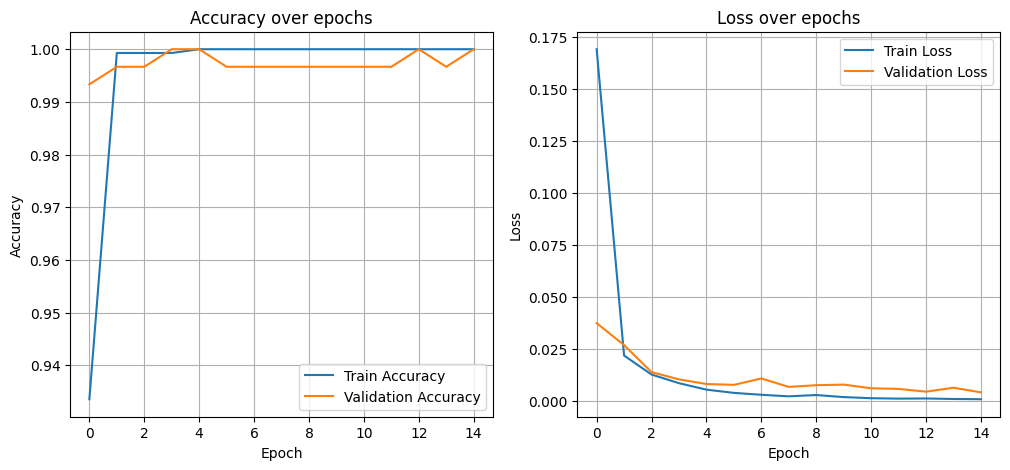

In [43]:
# Plot Loss and Accuracy
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [44]:
# Confusion matrix & metrics
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_data.classes
y_pred = (model.predict(test_data) > 0.5).astype(int).flatten()

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=["Unadulterated", "Adulterated"]))

10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step  
[[150   0]
 [  7 143]]
               precision    recall  f1-score   support

Unadulterated       0.96      1.00      0.98       150
  Adulterated       1.00      0.95      0.98       150

     accuracy                           0.98       300
    macro avg       0.98      0.98      0.98       300
 weighted avg       0.98      0.98      0.98       300



In [45]:
# Save Model
model.save("rice_bran_adulteration_mobilenetv2.h5")

In [10]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import tensorflow as tf

# Load your trained model
model = tf.keras.models.load_model("rice_bran_adulteration_mobilenetv2.h5")

# Path to folder containing new images
folder_path = r"C:\Users\NITRO V\OneDrive\Desktop\Rice_Bran_Infer\20%_2"

# Counters for predictions
adulterated_count = 0
unadulterated_count = 0
total_images = 0

# Loop over all images in the folder
for filename in os.listdir(folder_path):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
        total_images += 1
        img_path = os.path.join(folder_path, filename)
        
        # Load and preprocess image
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        
        # Predict
        pred = model.predict(img_array, verbose=0)[0][0]
        
        # Interpret prediction
# Interpret prediction
        if pred >= 0.5:
            label = "Unadulterated"   # flipped
            unadulterated_count += 1
        else:
            label = "Adulterated"     # flipped
            adulterated_count += 1

        
        print(f"{filename}: {label} (Confidence: {pred:.4f})")

# Calculate percentages
if total_images > 0:
    adulterated_percent = (adulterated_count / total_images) * 100
    unadulterated_percent = (unadulterated_count / total_images) * 100

    print("\n--- Batch Summary ---")
    print(f"Total images: {total_images}")
    print(f"Adulterated: {adulterated_count} ({adulterated_percent:.2f}%)")
    print(f"Unadulterated: {unadulterated_count} ({unadulterated_percent:.2f}%)")
else:
    print("No images found in the folder.")


im_ 0x1g.jpg: Adulterated (Confidence: 0.0838)
im_ 0x2g.jpg: Unadulterated (Confidence: 0.6073)
im_ 0x3g.jpg: Unadulterated (Confidence: 0.8779)
im_ 0x4g.jpg: Adulterated (Confidence: 0.2738)
im_ 0x5g.jpg: Adulterated (Confidence: 0.0394)
im_ 0x6g.jpg: Unadulterated (Confidence: 0.8782)
im_ 0x7g.jpg: Adulterated (Confidence: 0.2449)
im_ 0x8g.jpg: Unadulterated (Confidence: 0.5788)
im_ 0x9g.jpg: Unadulterated (Confidence: 0.5949)
im_ 0xag.jpg: Unadulterated (Confidence: 0.8405)
im_ 0xbg.jpg: Adulterated (Confidence: 0.0816)
im_ 0xcg.jpg: Adulterated (Confidence: 0.0477)
im_ 0xdg.jpg: Unadulterated (Confidence: 0.6096)
im_ 0xeg.jpg: Adulterated (Confidence: 0.0845)
im_ 0xfg.jpg: Adulterated (Confidence: 0.1840)
im_(nil)g.jpg: Adulterated (Confidence: 0.0128)
im_0x10g.jpg: Adulterated (Confidence: 0.0760)
im_0x11g.jpg: Unadulterated (Confidence: 0.7988)
im_0x12g.jpg: Unadulterated (Confidence: 0.9239)
im_0x13g.jpg: Unadulterated (Confidence: 0.9315)
im_0x14g.jpg: Unadulterated (Confidence

In [ ]:
# Save Model as TfLite
import tensorflow as tf

# Load your trained Keras model
model = tf.keras.models.load_model("rice_bran_adulteration_mobilenetv2.h5")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# # Optional: Enable optimization for smaller model
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# # Optional: Quantization (reduce float32 → int8)
# # converter.target_spec.supported_types = [tf.int8]

tflite_model = converter.convert()

# Save TFLite model
with open("rice_bran_adulteration_mobilenetv2.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model saved!")

2.20.0
